In [1]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import random

from spikingjelly.activation_based import layer, neuron, functional

import matplotlib.pyplot as plt

In [2]:
# 确保每次运行时，随机数种子是不同的
random_seed = int(time.time())
torch.manual_seed(random_seed)
random.seed(random_seed)

In [3]:
# 定义参数
DOWNLOAD_PATH = 'data'
OUTPUT_PATH='vit_mnist_print.txt'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000
N_EPOCHS = 5

In [4]:
torch.autograd.set_detect_anomaly(True)

In [5]:
# colorMNIST
def make_environment(images, labels, e):
    def torch_bernoulli(p, size):
        return (torch.rand(size) < p).float()
    def torch_xor(a, b):
        return (a - b).abs()  # Assumes both inputs are either 0 or 1
    # 2x subsample for computational convenience
    images = images.reshape((-1, 28, 28))[:, ::2, ::2]
    # Assign a binary label based on the digit; flip label with probability 0.25
    labels = (labels < 5).float()
    labels = torch_xor(labels, torch_bernoulli(0.25, len(labels)))
    # Assign a color based on the label; flip the color with probability e
    colors = torch_xor(labels, torch_bernoulli(e, len(labels)))
    # Apply the color to the image by zeroing out the other color channel
    images = torch.stack([images, images], dim=1)
    # images[torch.tensor(range(len(images))), (1 - colors).long(), :, :] *= 0
    images = images.clone()
    images[torch.tensor(range(len(images))), (1 - colors).long(), :, :] = 0
    return {
        'images': (images.float() / 255.),
        'labels': labels[:, None]
    }

In [6]:
# 打印结果以及输出到文件中
def print_info(string,file='vit_print.txt'):
    print(string)
    with open(file,'a') as f:
        f.write(string+'\n')

In [7]:
#残差模块，放在每个前馈网络和注意力之后
class Residual(nn.Module): # 通过连接层或者补充，保证fn输出和x是同维度的
    def __init__(self, fn): # 带function参数的Module，都是嵌套的Module
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x 

In [8]:
#layernorm归一化,放在多头注意力层和激活函数层。用绝对位置编码的BERT，layernorm用来自身通道归一化
class PreNorm(nn.Module): # 先归一化，再用function作用。
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim) # 三维的用dim，四维用[C,H,W]
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [9]:
#放置多头注意力后，因为在于多头注意力使用的矩阵乘法为线性变换，后面跟上由全连 接网络构成的FeedForward增加非线性结构
class FeedForward(nn.Module): # 非线性前馈，保持dim维不变
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.linear1 = layer.Linear(dim, hidden_dim)
        self.lif_node = neuron.LIFNode(tau=2.0)
        self.linear2 = layer.Linear(hidden_dim, dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.lif_node(x)
        x = self.linear2(x)
        self.lif_node.reset()  # 重置LIFNode层
        return x

In [10]:
#多头注意力层，多个自注意力连起来。使用qkv计算
class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = layer.Linear(dim, dim * 3, bias=False)
        self.to_out = layer.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [11]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([]) # ModuleList套ModuleList
        for _ in range(depth): # 叠加Attention块
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

In [12]:
#将图像切割成一个个图像块,组成序列化的数据输入Transformer执行图像分类任务。
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, '报错：图像没有被patch_size完美分割'
        num_patches = (image_size // patch_size) # ** 2
        patch_dim = 2 * channels * patch_size ** 2 # (P**2 C)：一个patch展平为向量后实际的长度

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) # +1是为了适应cls_token
        self.patch_to_embedding = layer.Linear(patch_dim, dim) # 将patch_dim（原图）经过embedding后得到dim维的嵌入向量
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            layer.Linear(dim, mlp_dim),
            neuron.LIFNode(),
            layer.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        # print(f"Shape after rearrange: {x.shape}")  # 添加打印语句
        # print(f"Shape of patch_to_embedding weight: {self.patch_to_embedding.weight.shape}")  # 添加打印语句
        x = self.patch_to_embedding(x)
        # print(f"Shape after patch_to_embedding: {x.shape}")  # 添加打印语句
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        # print(f"Shape of cls_tokens: {cls_tokens.shape}")  # 添加打印语句
        x = torch.cat((cls_tokens, x), dim=1)
        # print(f"Shape after concatenation: {x.shape}")  # 添加打印语句
        x = x + self.pos_embedding
        # print("Shape after adding pos_embedding: ", x.shape)  # 添加打印语句
        x = self.transformer(x, mask)
        # print("Shape after transformer: ", x.shape)  # 添加打印语句
        x = self.to_cls_token(x[:, 0])
        # print("Shape after to_cls_token: ", x.shape)  # 添加打印语句
        y = self.mlp_head(x)
        # print("Shape after mlp_head: ", y.shape)  # 添加打印语句
        
        # 重置所有LIFNode层
        for module in self.mlp_head:
            if isinstance(module, neuron.LIFNode):
                module.reset()
                
        return y

In [13]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        target = target.squeeze().long()  # 去掉多余的维度
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        functional.reset_net(model)

        if i % 10 == 0:
            # print_info('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                #   ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                #   '{:6.4f}'.format(loss.item()), OUTPUT_PATH)
            loss_history.append(loss.item())

In [14]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            target = target.squeeze().long()  # 去掉多余的维度
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print_info('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n',OUTPUT_PATH)

In [15]:
# 加载数据
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 标准化到[-1, 1]之间
])

In [16]:
data_path = "datasets"


# 加载 MNIST 数据集
train_dataset = torchvision.datasets.MNIST(
    root=data_path,
    train=True,
    transform=transform,
    download=True
)

In [17]:
train_dataset = make_environment(train_dataset.data, train_dataset.targets, 0.2)

# 打印 train_dataset 的信息
print(f"Number of images: {len(train_dataset['images'])}")
print(f"Shape of one image: {train_dataset['images'][0].shape}")
print(f"Label of first image: {train_dataset['labels'][0]}")

Number of images: 60000
Shape of one image: torch.Size([2, 14, 14])
Label of first image: tensor([0.])


In [18]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=list(zip(train_dataset['images'], train_dataset['labels'])),
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True
)

In [19]:
test_set = torchvision.datasets.MNIST(
    root=data_path,
    train=False,
    transform=transform,
    download=True
)

test_set = make_environment(test_set.data, test_set.targets, 0.2)

test_data_loader = torch.utils.data.DataLoader(
    dataset=list(zip(test_set['images'], test_set['labels'])),
    # dataset=test_set,
    batch_size=128,
    shuffle=True,
    drop_last=False,
    num_workers=4,
    pin_memory=True
)

In [20]:
# 确保每次运行时，模型的初始参数是随机的
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1, # 模型
            dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001) # 优化器

In [21]:
start_time = time.time() # 记录时间
train_loss_history, test_loss_history = [], [] # 精度记录
for epoch in range(1, N_EPOCHS + 1):
    temp_time=time.time()
    print_info(f'Epoch: {epoch}\n',OUTPUT_PATH)
        
    train_epoch(model, optimizer, train_data_loader, train_loss_history) # 训练一epoch
    evaluate(model, test_data_loader, test_loss_history) # 评估
    
    print_info(f'spend {(time.time()-temp_time)/60} min\n',OUTPUT_PATH)

Epoch: 1


Average test loss: 0.4846  Accuracy: 7938/10000 (79.38%)

spend 0.6584936499595642 min

Epoch: 2


Average test loss: 0.4696  Accuracy: 7958/10000 (79.58%)

spend 0.6613768895467123 min

Epoch: 3


Average test loss: 0.4669  Accuracy: 7943/10000 (79.43%)

spend 0.6433940768241883 min

Epoch: 4


Average test loss: 0.4571  Accuracy: 7989/10000 (79.89%)

spend 0.6468313177426656 min

Epoch: 5


Average test loss: 0.4551  Accuracy: 7959/10000 (79.59%)

spend 0.6465218464533488 min



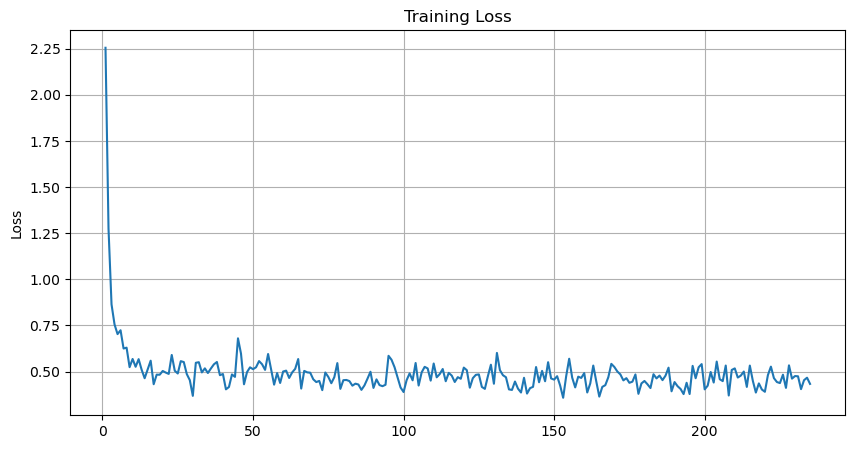

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history)
plt.title('Training Loss')
# plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

In [23]:
print_info('Execution time:'+ '{:5.2f}'.format((time.time() - start_time)/60) + ' min \n',OUTPUT_PATH)

Execution time: 3.26 min 

